In [1]:
import numpy as np
import matplotlib.pyplot as plt


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from tqdm import tqdm_notebook
import regex as re

import os

In [4]:
IUPAC_WILDCARDS = {
    "W" : "AT",
    "S" : "CG",
    "M" : "AC",
    "K" : "GT",
    "R" : "AG",
    "Y" : "CT",
    "B" : "CGT",
    "D" : "AGT",
    "H" : "ACT",
    "V" : "ACG",
    "N" : "ACGT",
}

In [5]:
reverse = {
    "W" : "W",
    "S" : "S",
    "M" : "K",
    "K" : "M",
    "R" : "Y",
    "Y" : "R",
    "B" : "V",
    "D" : "H",
    "H" : "D",
    "V" : "B",
    "N" : "N",
    "A" : "T",
    "C" : "G", 
    "T" : "A",
    "G" : "C",
    "(" : "(",
    ")" : ")"
}

In [6]:
def rc(x, reverse = reverse, r=0):
    d = dict(zip(reverse.keys(), reverse.values()))
    if r:
        d["("] = ")"
        d[")"] = "("
        return ''.join([d[y] for y in x][::-1])
    else:
        return ''.join([d[y] for y in x])

In [7]:
def read_fastq(path):
    with open(path) as f:
        lines = f.readlines()
    
    reads = [x[:-1] for x in lines[1::4]]
    qualities = [x[:-1] for x in lines[3::4]]
    
    return reads, qualities

In [8]:
def repeat_to_re_pattern(repeat, e=2, d = IUPAC_WILDCARDS):
    re_pattern = "("
    for char in repeat:
        if char not in d.keys() and char != '(' and char != ')':
            re_pattern += char
        elif char in d.keys():
            re_pattern += "[" +  "|".join(d[char]) + "]"
    
    re_pattern += "){e<=" + str(e) + "}"
    return re_pattern

In [9]:
def find(repeat, read, e = 2):
    p_str = repeat_to_re_pattern(repeat,e=e)
    p = re.compile(p_str)
   
    return [x.span() for x in re.finditer(p, read)]

In [10]:
def split_read(read, quality, repeat, e=2, v=0):
    repeat, repeat_s, repeat_e = repeat.r, repeat.rs, repeat.re
    repeat_pos = find(repeat, read, e)
    
    if v: print(repeat_pos)
    if len(repeat_pos) == 0:
        return [-1, -1], [-1, -1]

    else:
        repeat_pos = repeat_pos[0]
        read_left = read[:repeat_pos[0]]
        q_left = quality[:repeat_pos[0]]
        
        read_right = read[repeat_pos[1]:]
        q_right = quality[repeat_pos[1]:]
        
        
        repeat_pos_l = find(repeat_e, read_left, e)
        if v: print(repeat_pos_l)
        if len(repeat_pos_l) == 0:
            left_spacer = -1
            left_sp_q = -1
        else:
            left_spacer = read_left[repeat_pos_l[0][1]:]
            left_sp_q = q_left[repeat_pos_l[0][1]:]
            
        
        repeat_pos_r = find(repeat_s, read_right, e)
        if v: print(repeat_pos_r)
        if len(repeat_pos_r) == 0:
            right_spacer = -1
            right_sp_q = -1
        else:
            right_spacer = read_right[:repeat_pos_r[0][0]]
            right_sp_q = q_right[:repeat_pos_r[0][0]]
            
        if left_spacer != -1 and len(left_spacer) <= 10:
            left_spacer = -1
        if right_spacer != -1 and len(right_spacer) <= 10:
            right_spacer = -1
        
        return [left_spacer, right_spacer], [left_sp_q, right_sp_q]

In [11]:
quality_symbols1 = r'!"#$%&' 
quality_symbols2 = "'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\]^_`abcdefghijklmnopqrstuvwxyz{|}~"

In [37]:
get_quality('')

32

In [41]:
quality_dict_r[40]

'I'

In [38]:
quality_dict = {}
quality_dict_r = {}
for i, char in enumerate(quality_symbols1 + quality_symbols2):
    quality_dict[char] = i
    quality_dict_r[i] = char

In [13]:
get_quality = lambda x: quality_dict[x]

In [14]:
def get_lowest_q(pair_q, gq = get_quality):
    return quality_dict[min(pair_q[0] + pair_q[1], key=gq)]

In [15]:
def save_pairs(path, name, pairs):
    name = name.split(".")[0]
    with open(path + name, 'w') as f:
        for p in pairs:
            f.write("\t".join(p))
            f.write("\n")
            

In [16]:
def main(path, name, repeat,  t = 10, v = 1):
    if v: print("reading :", name)
    reads, qualities = read_fastq(path + name)
    
    
    if v: print("cutting :", name)
    pairs, pairs_q = [], []
    for r,q in tqdm_notebook(zip(reads, qualities)):
        p, pq = split_read(r, q, repeat, e = 4)
        pairs.append(p)
        pairs_q.append(pq)
    
    
    if v: print("masking :", name)  
    pairs = np.array(pairs)
    pairs_q = np.array(pairs_q)
    
    
    mask = np.array(['-1' not in pair for pair in tqdm_notebook(pairs)])

    pairs = pairs[mask]
    pairs_q = pairs_q[mask]
      
    
    if mask.sum() ==0:
        return [], [], []
        
    min_pq = np.array([get_lowest_q(pq) for pq in pairs_q])
    
    mask_2 = min_pq >= t
    
    print(name, mask.sum(), min(min_pq))
    
    return pairs, pairs_q, min_pq, mask_2

In [17]:
class Repeat:
    def __init__(self, r, rs, re, rc):
        self.r = r
        self.rs = rs
        self.re = re
        self.rc = rc

In [18]:
redundant = Repeat("GTTTTAKATTA(ACTAWRTGG)WATGTAAAK", 
                   "GTTTTAKATTAACTAWRTGG",
                   "ACTAWRTGGWATGTAAAK",
                   "GTTTTAKATTAACTAWRTGGWATGTAAAK")

non_redundant_1 = Repeat("GTTTTATATTA(ACTAAGTGG)TATGTAAAG",
                           "GTTTTATATTAACTAAGTGG",
                           "ACTAAGTGG)TATGTAAAG",
                           "GTTTTATATTAACTAAGTGGTATGTAAAG"
                          )

non_redundant_2 = Repeat("GTTTTATATTA(ACTATATGG)AATGTAAAT",
                           "GTTTTATATTAACTATATGG",
                           "ACTATATGGAATGTAAAT",
                           "GTTTTATATTAACTATATGGAATGTAAAT"
                          )

In [19]:
Forward: GCG CCA GCG GGG ATA AAC C

Reverse: CGC TGG CGC GGG GAA CWC

SyntaxError: invalid syntax (<ipython-input-19-1c59796544e0>, line 1)

In [ ]:
GWGTTCCCCGCGCCAGCG
         GCGCCAGCGGGGATAAACC
"GWGTTCCCC(GCGCCAGCG)GGGATAAACCG"

In [ ]:
"GWGTTCCCC(GCGCCAGCG)GGGATAAACCG"[::-1]

In [ ]:
ecoli_r = Repeat("GWGTTCCCC(GCGCCAGCG)GGGATAAACCG", 
                   "GWGTTCCCCGCGCCAGCG",
                   "GCGCCAGCGGGGATAAACCG",
                   "GWGTTCCCCGCGCCAGCGGGGATAAACCG")

ecoli_r_1 = Repeat("GWGTTCCCC(GCGCCAGCG)GGGATAAACCG", 
                   "GCCAAATAGGGGCGACCGCG",
                   "GCGACCGCGCCCCTTGWG",
                   "GCCAAATAGGGGCGACCGCGCCCCTTGWG")

ecoli_r_2 = Repeat("CGGTTTATCCC(CGCTGGCGC)GGGGAACWC", 
                   "CGGTTTATCCCCGCTGGCGC",
                   "CGCTGGCGCGGGGAACWC",
                   "CGGTTTATCCCCGCTGGCGCGGGGAACWC")


In [ ]:
rc(ecoli_r_1.rc)

In [24]:
def filter_by_q(pairs, pairs_q, t = 10):
    min_pq = np.array([get_lowest_q(pq) for pq in pairs_q])
    
    mask_2 = min_pq >= t
    
    return pairs, pairs_q, min_pq, mask_2

In [25]:
path = "../data/student_Dvyg/EC/gz/"
#path = "../data/clostr_Polina/fastq/"

In [26]:
names = sorted(os.listdir(path))

In [27]:
def f(x):
    return main(path, x, ecoli_r_1)

In [23]:
res = f(names[0])

reading : DVyg24_S463_R1_001.fastq
cutting : DVyg24_S463_R1_001.fastq


A Jupyter Widget


masking : DVyg24_S463_R1_001.fastq


A Jupyter Widget


DVyg24_S463_R1_001.fastq 184413 2


In [32]:
res[3].sum()

184410

In [33]:
len(res[0])

184413

In [40]:
res_20 = filter_by_q(res[0], res[1], 20)

In [42]:
res_20[-1].sum()

101381

In [43]:
pairs = np.array(res_20[0])[res_20[-1]]

In [45]:
save_pairs("../data/student_Dvyg/EC/pairs_4/", names[0], pairs)

## hu

In [104]:
import sys
sys.path.append("./utils/")
import hierarcical_utils as hu
import plot_utils as pu 

In [105]:
import hamiltonian_utils as hamu

In [48]:
%time gr = hu.graph_from_raw("../data/student_Dvyg/EC/DVyg26_S465_R1_001_pairs.txt", split=' ', n_jobs=8, mp = 1)

reading pairs, clustering...
making sp_to_n...


A Jupyter Widget


processing pairs...
Using 8 jobs


A Jupyter Widget


making graph...
CPU times: user 413 ms, sys: 96.4 ms, total: 510 ms
Wall time: 5.2 s


In [112]:
path = "../data/student_Dvyg/EC/pairs_spget_20//"
names = sorted(os.listdir(path))

In [113]:
grs_20 = [hu.graph_from_raw(path + name, split=' ', n_jobs=8, mp = 1) for name in tqdm_notebook(names[::2])]

A Jupyter Widget

reading pairs, clustering...
making sp_to_n...


A Jupyter Widget

processing pairs...
Using 8 jobs


A Jupyter Widget

making graph...
reading pairs, clustering...
making sp_to_n...


A Jupyter Widget

processing pairs...
Using 8 jobs


A Jupyter Widget

making graph...
reading pairs, clustering...
making sp_to_n...


A Jupyter Widget

processing pairs...
Using 8 jobs


A Jupyter Widget

making graph...
reading pairs, clustering...
making sp_to_n...


A Jupyter Widget

processing pairs...
Using 8 jobs


A Jupyter Widget

making graph...



In [114]:
[x[0].sum() for x in grs_20]

[87092.0, 21279.0, 84350.0, 41176.0]

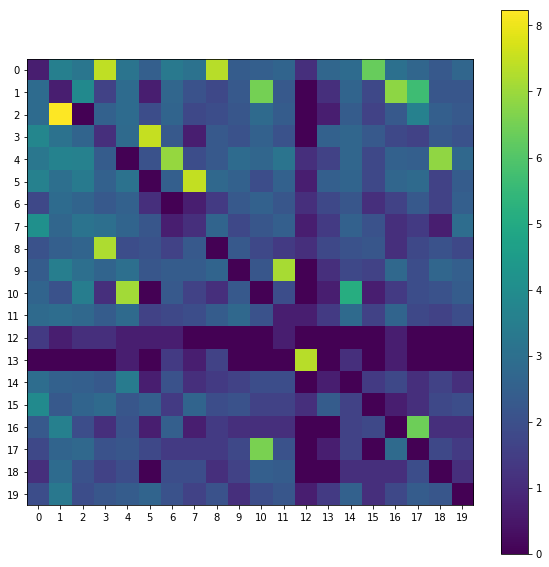

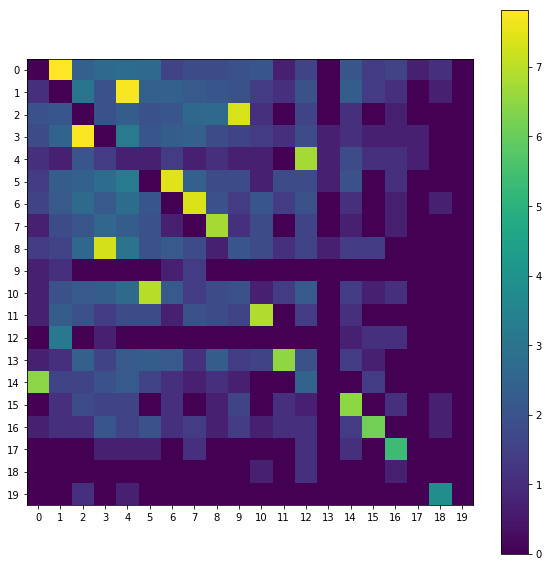

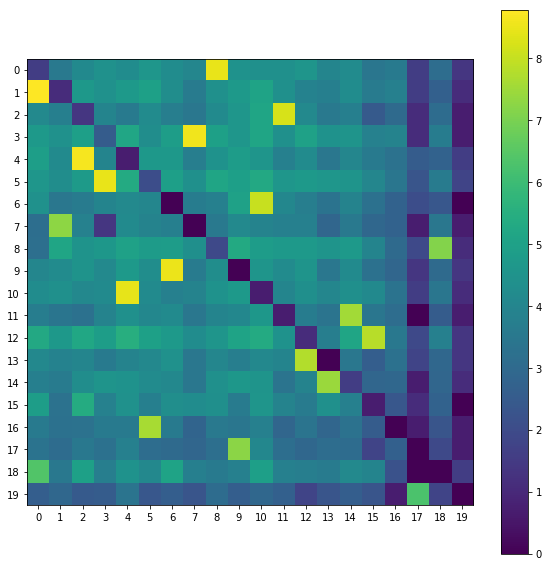

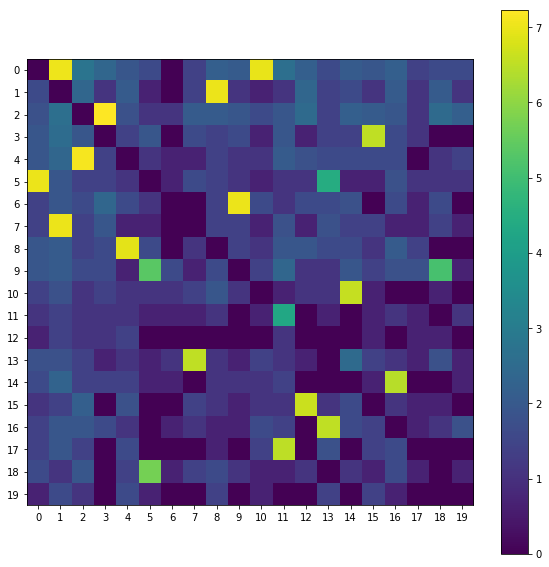

In [211]:
for gr in grs_20:
    pu.plot_gr(gr[0][:20, :20], log =1, all_ticks=1)

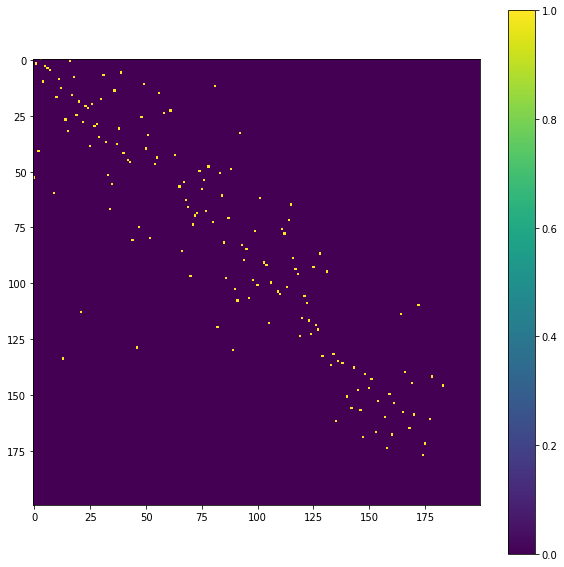

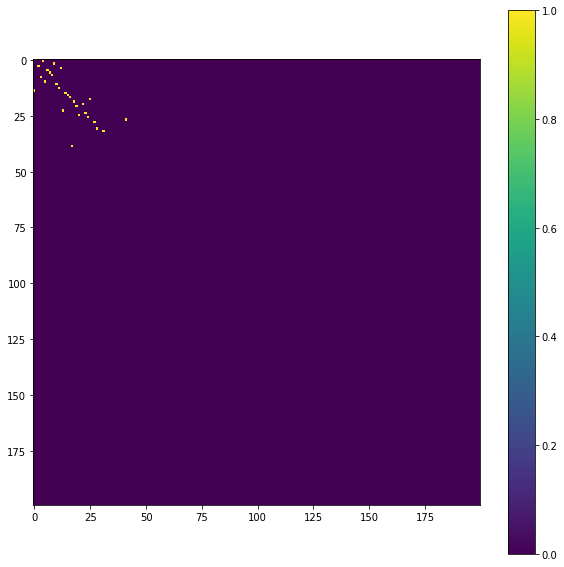

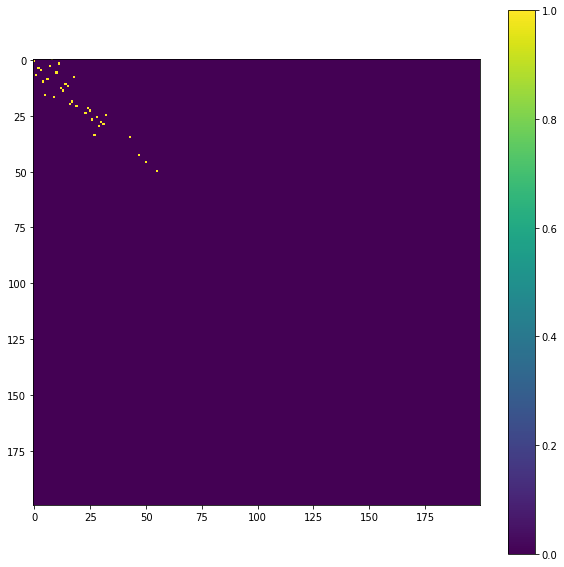

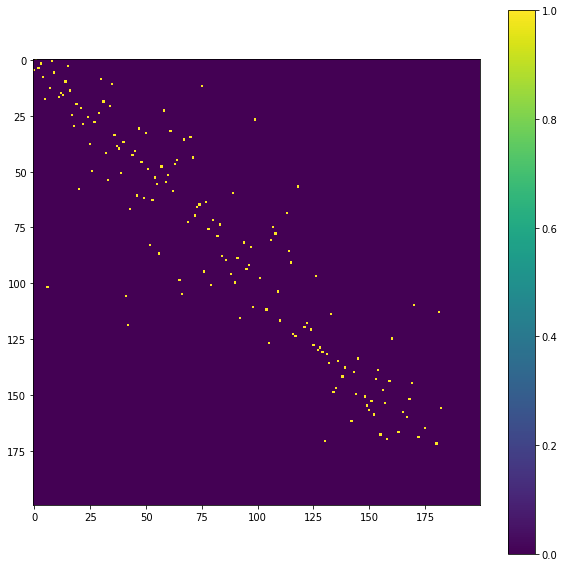

In [154]:
for gr in res_20_mask:
    pu.plot_gr(hamu.list_to_gr(gr[0], 500)[:200,:200])

In [120]:
res_20 = [hamu.restore_arrays(gr[0],threashold=5) for gr in grs_20]

In [130]:
def mask(arrs, ws, l = 2):
    arrs = np.array(arrs)
    ws = np.array(ws)
    mask = np.array([len(x) for x in arrs]) > l
    return arrs[mask], ws[mask]

20::

24 - 



25 - 
[22, 24, 23, 25, 32] - 12, кассета 2
[34, 27, 26, 28, 30, 29, 31] - 67 кассета 1


26 - 
[22, 24, 23, 25, 32] - 12, кассета 2
[34, 27, 26, 28, 30, 29, 31] - 67 кассета 1



In [159]:
res_20_mask = [mask(*x) for x in res_20]

In [257]:
idx = -1

In [264]:
answ_n

[[171, 130, 127, 105, 66, 73, 69, 113],
 [119, 42, 32, 61],
 [32, 61, 46, 48, 57, 118, 122],
 [182, 203, 78, 286, 218, 260, 11, 266, 55, 145],
 [42, 32, 68, 93],
 [102, 6, 9, 30, 18, 5, 0, 10, 14, 16, 13, 7, 1, 8, 4],
 [102, 6, 9, 5, 0, 1, 8, 4, 2, 3, 15, 12, 75, 107],
 [102, 6, 9, 18, 5, 13, 7],
 [23, 54, 33, 26, 24, 29, 22, 21, 34, 36, 67, 43, 44, 71],
 [23, 41, 85, 45, 100, 90, 86, 114, 133],
 [123, 116, 92, 96, 88, 84, 97, 126],
 [186, 137, 191, 111, 177, 268, 79, 119, 244],
 [23, 20, 19, 31, 47],
 [23, 33, 26, 24, 29, 22, 21, 34, 36, 67, 43, 44, 71],
 [186, 191, 192, 111, 98, 101, 79, 82, 94, 95, 76, 78, 108],
 [23, 20, 19, 31, 47]]

In [259]:
res_20_mask[idx][0]

array([list([102, 6, 9, 30, 18, 5, 0, 1, 8, 4, 2, 3, 15, 12, 75, 107]),
       list([10, 14, 16, 13, 7]),
       list([87, 56, 55, 59, 62, 49, 51, 39, 37, 40, 38, 25, 17, 11, 35, 70, 72, 80]),
       list([23, 58, 20, 19, 31, 47, 63, 53, 54, 33, 50, 26, 24, 29, 22, 21, 34, 36, 67, 43, 44, 71]),
       list([28, 27, 99, 65, 74, 83, 52, 60, 89, 91, 115]),
       list([119, 42, 32, 61, 46, 48, 57, 118, 122]),
       list([81, 106, 41, 45, 64, 77]),
       list([171, 130, 127, 105, 66, 73, 69, 113, 181]),
       list([111, 98, 101, 79, 82, 94, 95, 76, 78, 108]),
       list([123, 116, 92, 96, 88, 84, 97, 126]),
       list([100, 90, 86, 114, 133]), list([225, 112, 104, 109]),
       list([120, 121, 124, 117, 110, 170, 158, 165, 175]),
       list([147, 135, 136, 132, 131, 129, 128, 125, 160, 167, 163]),
       list([162, 142, 138, 139, 154, 157, 150, 144, 159, 152, 168, 155, 149, 134, 145, 169, 172, 180]),
       list([140, 143, 153, 151, 148, 156, 182])], dtype=object)

In [265]:
res_20_mask[idx][1]

array([list([89.0, 1110.0, 447.0, 462.0, 306.0, 1111.0, 1148.0, 1104.0, 1016.0, 1245.0, 1370.0, 685.0, 761.0, 175.0, 80.0]),
       list([723.0, 631.0, 693.0, 678.0]),
       list([126.0, 225.0, 198.0, 210.0, 170.0, 229.0, 147.0, 312.0, 232.0, 315.0, 215.0, 547.0, 675.0, 369.0, 177.0, 166.0, 152.0]),
       list([203.0, 229.0, 624.0, 471.0, 255.0, 200.0, 201.0, 218.0, 157.0, 255.0, 169.0, 520.0, 499.0, 378.0, 589.0, 396.0, 322.0, 174.0, 170.0, 288.0, 162.0]),
       list([580.0, 47.0, 101.0, 192.0, 132.0, 97.0, 221.0, 73.0, 124.0, 60.0]),
       list([57.0, 295.0, 232.0, 193.0, 252.0, 230.0, 57.0, 41.0]),
       list([36.0, 85.0, 187.0, 196.0, 185.0]),
       list([9.0, 19.0, 32.0, 92.0, 178.0, 162.0, 64.0, 7.0]),
       list([69.0, 88.0, 90.0, 132.0, 117.0, 59.0, 115.0, 164.0, 85.0]),
       list([49.0, 65.0, 109.0, 64.0, 129.0, 116.0, 34.0]),
       list([87.0, 116.0, 68.0, 20.0]), list([6.0, 55.0, 93.0]),
       list([56.0, 37.0, 39.0, 64.0, 6.0, 9.0, 14.0, 9.0]),
       list([20.0,

In [260]:
[grs_20[idx][4][x] for x in res_20_mask[idx][0][2]]

['TGTTCGGCGGGGCGGTAGTACCACTGTTTTTT',
 'ATCAACATGCAGCGCGAACGGCTGCCCCTCGC',
 'AATCGTGTGTAAATTCGCGGCGGCTCCACTG',
 'TGGTCGAAATATAGACAGCATGTTCCGTACCA',
 'ATTTTGCTGGGAGTCATTCCCAGCTCCGTAA',
 'ACCCCGGATAAAGGTTTACCAGTGTTACGGTC',
 'GCTACATGGAGACGCATCATGACGTACAAAA',
 'TCCAACCTTCCATGAGATACGCGCATTAGCGG',
 'CGTGACCGCCTGTACACGCTGTAATGGCTCA',
 'ACACTATCCGGGCGGTATTACGCCCAAATATC',
 'CTGCCGGGTGAAACCACTCGCGGCAGATCTT',
 'GCGCCGATGTGATGGGATAGTTGCTCTGCCAG',
 'GTTTCGAGTCGATGAAACAGCAGGTAATCAGT',
 'GTCGACCATATGCCAAGACCAACTATCTGAT',
 'GCCGGTTCGCGCCGGGTCGAACCCGCCCCAC',
 'TCATCATTATCTGGATTATCTAATTCGTCAG',
 'GCGATCGGCGTGCTGGATAAACTGGAGGAGC',
 'CGCCAGCAGCACAGCAACAGCGAGGTAACCA']

In [261]:
answ = ["ACATGAATGTCGGTTCAGACCGTGTTTTTACC	AGTGCTGGACCATTTCAAATTCACAATAGATT	GGAATGATATTTCAATAAATAATTATAACAAT	TTTTTGTTAATTGCGTTTGCCACGGTTTGCAA	TGAGCGTCGGCGGCTCGCTGGATTTGCGCGG	AATGCATCAGTTGAACACAAAAGTAGCTTTTC	TAAACCACCAGCCAGACCACCAATTACCACAC	GCGATGGATCAGGGTATTACACTCGACGGCGG",
       "TTACTGCTTGGTATGCGGAATCACACCCTGAA	TGAAGCATCAAACATTTGGTGGACCAAACGGA	TGTACGCGGCGAGTTTTAGCGACAGGTCATCC	GATCTGCCAGCGCCTCTGCGGGGCGGTAAAC", 
        "TGTACGCGGCGAGTTTTAGCGACAGGTCATCC	GGATCTGCCAGCGCCTCTGCGGGGCGGTAAAC	TACGCCAGCCACCTGCTTCGCCAGCCGTTCGG	TCACGGTAGCGCCACTGCGCGTCGGTGACGGG	AACGAACAGGGATTTGTCGGCAGTTTCTTTAC	ATAATTCGCAAATCAATATATATTTTGTCCGT	GGGTGCGGATGCTCCCGGAATTGCGCGGGCAA",
       "TTGGTTGTTCGGCGTTTTGAAGAGAACAAAAA	TTCCCGCGCGATTGCGATCGCCATCGTCCGAT	TATATAAACGAGGTGAATTTATGGAAACTGTA	TTTTTATGCGTGGCAGTAAATCCCCACGTCGG	CGGCGAAAGCGGATGCGTTCACCAATGGTCAT	AAACAGATTGTTCGTTTTCCCCATATTCATGA	GGTGAACCCCATCACCAAGAACATGAAGCCGT	TGAGGTATTCCGCCAGGGCGGACAATTTATCA	AAGCGCGCCCCATTTAACGCCGCTGCCGACGG	CCTTTTGATATTCGTGAACCAGACTTTTT",
       "AGAAGCATCGAAATTTGGGGGACCGGCGGA	TGTACGCGGCGAGTTTTAGCGACAGGTCATCC	ATTCAAAATTACTCGTTGAGGAAATATATAGT	CGCTGTTAGACGCCCTGTTTGATGATGACGCC",
        "AAAACCAAACTTCTCCATAAATTCCATAGCCG	GAGTCTATCAGCGACACTACCGGCAATAGCGA	CTATAGCGCCACGTTCCGAGCGCTGCGAGCTG	GGCCTATGCGTTTTTCTCTCTGTTAATGCGCCCC	CTAATGAGTCAGTTTGAACAGATCCCCGACAA	GGCTTTAAAATTGTGTTCCCGTCTGGCGCTGG	GAGAGTGCTGACAGGTGTCTCGATTACCTGAT	GGTAGTACGCGCCTCCGGACGTTTTTATGTCG	TCTTCGCGGGTAATCAATGATGATTCAGTTTC	GAACGCAATATCACGGCGTTCTGCGGCCTCGG	GCATCCATGCCGACGCCTTTACGTGTGCGGGG	GCGCGAATTTGTGCGCATGGGGCGCATTTTTGG	ACGGTCCATGGCACACAGGATCCAGACGTTAA	ACGATGGCGATGCGTGAGAAAGGGGGTCGATA	AGTTCGCTGAGTAGCCTTTTTTCTGTGCCTAA",
        "AAAACCAAACTTCTCCATAAATTCCATAGCCG	GAGTCTATCAGCGACACTACCGGCAATAGCGA	CTATAGCGCCACGTTCCGAGCGCTGCGAGCTG	GGCTTTAAAATTGTGTTCCCGTCTGGCGCTGG	GAGAGTGCTGACAGGTGTCTCGATTACCTGAT	ACGGTCCATGGCACACAGGATCCAGACGTTAA	ACGATGGCGATGCGTGAGAAAGGGGGTCGATA	AGTTCGCTGAGTAGCCTTTTTTCTGTGCCTAAC	GAGGTGGCAATACGCGTAGATCATTTGGTCGT	CAAAATATTACGAGCTTCGTCAGGCCATGGAC	GTAACGTCTGCCTTTTCCTCGTCCGCCTTAAT	CCTGTCATTCTGGCGGTAAAATCGATCTGCCA	ATTAGCATCCCCGTGAATAATTTTCTATTTTTAG	GCGCGCGTGACGCGTTTTTTTTTTCAGTCGTGAC",
        "AAAACCAAACTTCTCCATAAATTCCATAGCCG	GAGTCTATCAGCGACACTACCGGCAATAGCGA	CTATAGCGCCACGTTCCGAGCGCTGCGAGCTG	CTAATGAGTCAGTTTGAACAGATCCCCGACAA	GGCTTTAAAATTGTGTTCCCGTCTGGCGCTGG	GCATCCATGCCGACGCCTTTACGTGTGCGGGG	GCGCGAATTTGTGCGCATGGGGCGCATTTTTGG",
        
        "CCCGCATTCAGACGTTTCAAATTGAGAGG	CCGTCCACCCTGATAGCCGCCCTTGTGATC	TACTGCTCCGCGGCGTTTCTCCCTCGCCCAG	TCATTTCCCATGCAAAATGCTGCATTCCTGGC	AGTGGCAGGCCGGTAATATGAAAACGACAGAG	ATCTTCTTGTTCAGGAACGTCAGTAGAGGTGT	AGCATTAACCCCCACCAGCTCGACGTGTGTGG	GCGGGCGTTAACGCGGTGATACTGTTTGACGG	ACCGAGCGCCGCTGGGAGGCGTATCTCACGTT	TGAATGATCGGAAAGACGCTGCAAAGGCAATG	TACCAAACCGGAATCGCTCCATATAACGGCGG	CAACCCGGCGGCACGGTCAATCGTTGCGTCAG	GACTCAAAACGGCGCAGGTCAAAATCGTTCAA	GGTGAATACTGCGGCAGGCGCTGCGGGAATTG",
        "GCCTGACATTGCAGACGTTACAAATTGAGAGG	TACCGGTGTGAATTACAGCACCACCGCCACCC	CAAACAGGTCGACATGTTTGGCTAACAGCTAA	CGATAACACAGGGCCGTCAATGCGGCCCTTTT	TTTTACCGTAACGCAGCACAAGACACGCTCCG	CCCAGATGACAGCTTGCCTAAAACGAAAGCAG	GGCGAACAACCGACCCCTGTTGGACCCGACGA	GCGGAAAACAGCCAAAATAACGCAATTACCGC	AGCAGCAACAATATTAACGCGCAGTGCTGCCAG",
        "ATATACAGCAAACCTTCAGAATGCATTCCGGG	GCCGTCTGCCTCCAGCCCAGCCCTGGATATTT	TGGTTCACTCACGCAACGTCTGAGCGCGTTGA	AGGGCCGCCGCTACCCCAGAAGTGCCACTCCC	GCGTATCGTCTCGTTATTGCGCCGCCCCAACT	AGTATGCGTTCAATCACTGTCAGGCCTACTTC	AGTTGCCCGATGGACACTCCCAGACCATCAGC	ACTAAACTTAATGATGGCCGTTACAGCGTGGA",
        "AACATCGGAAACGGCTTCGCGGCGGCGGCGTC	GACAGAACGGCCTCAGTAGTCTCGTCAGGCTC	TACGTGAAGAATATTTGCAACACCCGCAAGAA	GCCCGCCTCGTCGGTGTATTCCGCGAGATCGC	ATGCTTTTATTCGTCGCGTCTGGCTCAGATTG	AGCCATTGTTTAAAAATCTCGTCCCGTTCTAT	ACGTAACGAGGCACTGGACTGCCGAAACTACG	ATCCTCTTCGCTGCCGAATCCCTCTGTCGTTA	CACCCATCTTCCCTTATCGCCGGGTCGCGGAA",
        "GCCTGACATTGCAGACGTTACAAATTGAGAGGC	ATCACGATAACGCTGCTGTGATTCGTCCCCGTC	AAGACGACGTGATCCGCAAAGTCGAAGGCACGC	TGTTTTTCTGCCGGTTTAACACGGTGCGATAAC	TGTTTCTGTCCCAACTGAACAGCGCCGATAGTC",
        "GCCTGACATTGCAGACGTTACAAATTGAGAGG	TACTGCTCCGCTGGCGTTTCTCCCTCGCCCAG	TCATTTCCCATGCAAAATGCTGCATTCCTGGC	AGTGGCAGGCCGGTAATATGAAAACGACAGAG	ATCTTCTTGTTCAGGAACGTCAGTAGAGGTGT	AGCATTAACCCCCACCAGCTCGACGTGTGTGG	GCGGGCGTTAACGCGGTGATACTGTTTGACGG	ACCGAGCGCCGCTGGGAGGCGTATCTCACGTT	TGAATGATCGGAAAGACGCTGCAAAGGCAATG	TACCAAACCGGAATCGCTCCATATAACGGCGG	CAACCCGGCGGCACGGTCAATCGTTGCGTCAG	GACTCAAAACGGCGCAGGTCAAAATCGTTCAA	GGTGAATACTGCGGCAGGCGCTGCGGGAATTG",
        "AACATCGGAAACGGCTTCGCGGCGGCGGCGTC	ACGTGAAGAATATTTGCAACACCCGCAAGAA	GGCATAGCCAGGCTGATCCGGCGACGGCCTTA	GCCCGCCTCGTCGGTGTATTCCGCGAGATCGC	GTTATCACCGAGTGCAGTAGCCCGCGCGCGCT	GTCGCCGGGTTGATTTTCCATGATGATTTTTA	GTAACGTGGCGACGACCGGCGATTGATTTCAG	TCGAACCTGTTTTTCTTAGTGCGCGCAACGTC	CGTCCGGATCGGTTTCGAGAATCTCTACGCTC	GTTGTTGTAATAAAGCCCCGGAGTTTTATATC	GGGTTGACGCCAGCGAACATTGACTCAGATGC	TACAGTTAAGCGTAAAGTAAGTGATACTGGTG	GTTTTCATTTGCACGAGCTGCACCATAAGAAG",
        "GCCTGACATTGCAGACGTTACAAATTGAGAGGC	ATCACGATAACGCTGCTGTGATTCGTCCCCGTC	AAGACGACGTGATCCGCAAAGTCGAAGGCACGC	TGTTTTTCTGCCGGTTTAACACGGTGCGATAAC	TGTTTCTGTCCCAACTGAACAGCGCCGATAGTC"
       ]

In [239]:
answ = [
    "ACATGAATGTCGGTTCAGACCGTGTTTTTACC	AGTGCTGGACCATTTCAAATTCACAATAGATT	GGAATGATATTTCAATAAATAATTATAACAAT	TTTTTGTTAATTGCGTTTGCCACGGTTTGCAA	TGAGCGTCGGCGGCTCGCTGGATTTGCGCGG	AATGCATCAGTTGAACACAAAAGTAGCTTTTC	TAAACCACCAGCCAGACCACCAATTACCACAC	GCGATGGATCAGGGTATTACACTCGACGGCGG",
    "ACATGAATGTCGGTTCAGACCGTGTTTTTACC	AGTGCTGGACCATTTCAAATTCACAATAGATT	GGAATGATATTTCAATAAATAATTATAACAAT	TTTTTGTTAATTGCGTTTGCCACGGTTTGCAA	TGAGCGTCGGCGGCTCGCTGGATTTGCGCGG	AATGCATCAGTTGAACACAAAAGTAGCTTTTC	TTTTGCTGACACCGGCAATACTGAACGGCTGG	ACGGATTGCGGTATATGCAGTGTCCAGATTCT	TAAACCACCAGCCAGACCACCAATTACCACAC	GGGGATAACGGTTATCCACTGGCCGCCGATCT	TGTAATAGCCTGATCTCTGATCTCCCTCGCCT	CTGTCCCAGGCCGAGGCTGTATTTCAATCCTG	GCGATGGATCAGGGTATTACACTCGACGGCGG	GCTGCGGGTCAATCAACTGGAGTGCAAATCCCC	GTCGCGCGCCGACGGGAATAAACCGAATAAATTT	TCGTCAGGCACATACTGAGTTCGCAACAAA",
    "CCCGCATTCAGACGTTTCAAATTGAGAGG	CCGTCCACCCTGATAGCCGCCCTTGTGATC	TACTGCTCCGCGGCGTTTCTCCCTCGCCCAG	TCATTTCCCATGCAAAATGCTGCATTCCTGGC	AGTGGCAGGCCGGTAATATGAAAACGACAGAG	ATCTTCTTGTTCAGGAACGTCAGTAGAGGTGT	AGCATTAACCCCCACCAGCTCGACGTGTGTGG	GCGGGCGTTAACGCGGTGATACTGTTTGACGG	ACCGAGCGCCGCTGGGAGGCGTATCTCACGTT	TGAATGATCGGAAAGACGCTGCAAAGGCAATG	TACCAAACCGGAATCGCTCCATATAACGGCGG	CAACCCGGCGGCACGGTCAATCGTTGCGTCAG	GACTCAAAACGGCGCAGGTCAAAATCGTTCAA	GGTGAATACTGCGGCAGGCGCTGCGGGAATTG",
    "AACATCGGAAACGGCTTCGCGGCGGCGGCGTC	ACGTGAAGAATATTTGCAACACCCGCAAGAA	GGCATAGCCAGGCTGATCCGGCGACGGCCTTA	GCCCGCCTCGTCGGTGTATTCCGCGAGATCGC	GTTATCACCGAGTGCAGTAGCCCGCGCGCGCT	GTCGCCGGGTTGATTTTCCATGATGATTTTTA	GTAACGTGGCGACGACCGGCGATTGATTTCAG	TCGAACCTGTTTTTCTTAGTGCGCGCAACGTC	CGTCCGGATCGGTTTCGAGAATCTCTACGCTC	GTTGTTGTAATAAAGCCCCGGAGTTTTATATC	GGGTTGACGCCAGCGAACATTGACTCAGATGC	TACAGTTAAGCGTAAAGTAAGTGATACTGGTG	GTTTTCATTTGCACGAGCTGCACCATAAGAAG"
]

In [262]:
answ = [x.split("\t") for x in answ]

In [263]:
vals = [[hu.find_closest(grs_20[idx][3], x) for x in y] for y in answ]
answ_n = [[grs_20[idx][3][hu.find_closest(grs_20[idx][3], x)[1]] for x in y] for y in answ]
gr_answ = hamu.list_to_gr([[grs_20[idx][3][hu.find_closest(grs_20[idx][3], x)[1]] for x in y] for y in answ], grs_20[idx][0].shape[0])

## 40

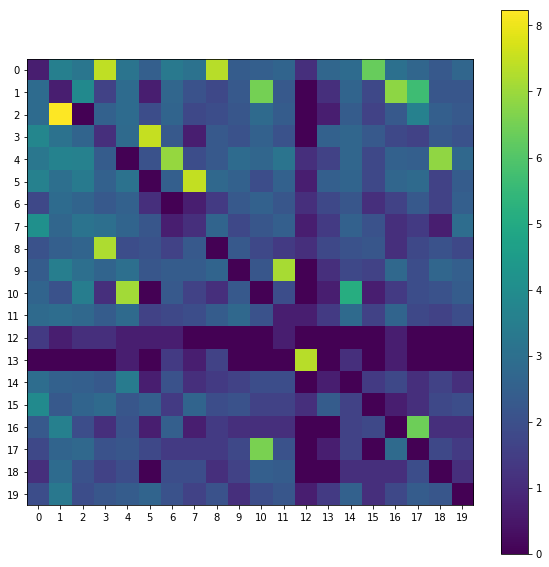

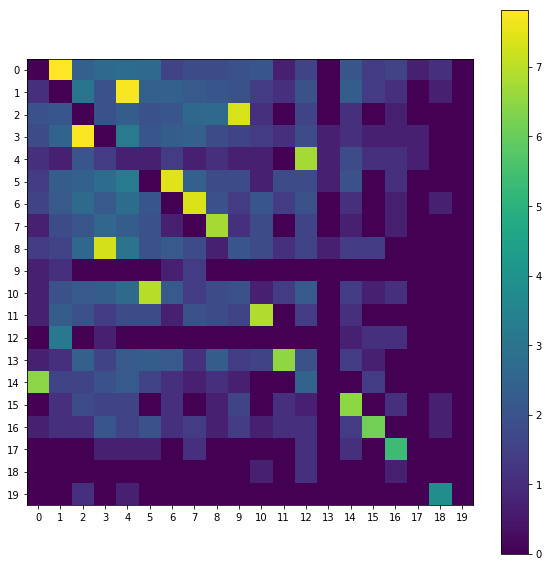

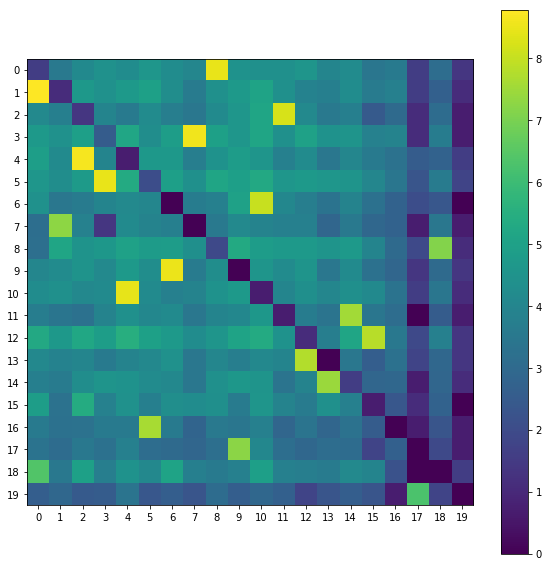

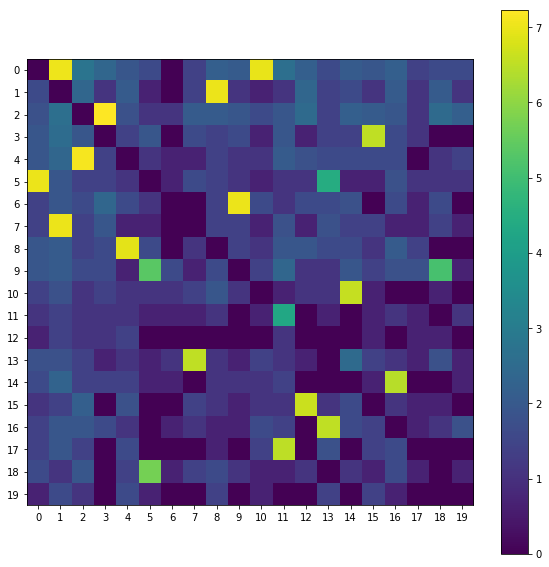

In [211]:
for gr2, gr4 in zip(grs_20, grs_40:
    pu.plot_gr(gr[0][:20, :20], log =1, all_ticks=1)

In [213]:
res_40 = [hamu.restore_arrays(gr[0],threashold=5) for gr in grs_40]

In [214]:
def mask(arrs, ws, l = 2):
    arrs = np.array(arrs)
    ws = np.array(ws)
    mask = np.array([len(x) for x in arrs]) > l
    return arrs[mask], ws[mask]

In [215]:
res_40_mask = [mask(*x) for x in res_40]

In [216]:
idx = 2

In [217]:
res_40_mask[idx][0]

array([list([24, 17, 2, 3, 7, 1, 0, 6, 16]),
       list([20, 19, 18, 11, 9, 12, 5, 4, 10, 15, 14, 8, 13]),
       list([21, 23, 22, 25, 31]), list([35, 28, 27, 30, 29, 26, 32])],
      dtype=object)

In [181]:
res_20_mask[idx][1]

array([list([694.0, 2071.0, 4805.0, 5449.0, 1445.0, 6484.0, 4876.0, 1267.0]),
       list([272.0, 534.0, 1386.0, 5043.0, 3091.0, 4755.0, 5666.0, 3821.0, 1899.0, 1714.0, 2391.0, 2531.0]),
       list([222.0, 183.0, 181.0, 38.0]),
       list([8.0, 78.0, 94.0, 40.0, 51.0, 37.0]), list([7.0, 11.0]),
       list([6.0, 6.0])], dtype=object)

In [182]:
[grs[idx][4][x] for x in res_20_mask[idx][0][0]]

['AACATCGGAAACGGCTTCGCGGCGGCGGCGTC',
 'GCGATGGATCAGGGTATTACACTCGACGGCGG',
 'GTAACGTGGCGACGACCGGCGATTGATTTCAG',
 'GGAATGATATTTCAATAAATAATTATAACAAT',
 'TTTTTGTTAATTGCGTTTGCCACGGTTTGCA',
 'TGAGCGTCGGCGGCTCGCTGGATTTGCGCGG',
 'AATGCATCAGTTGAACACAAAAGTAGCTTTT',
 'TACAGTTAAGCGTAAAGTAAGTGATACTGGTG',
 'GGCATAGCCAGGCTGATCCGGCGACGGCCTTA']

In [183]:
answ = [
    "ACATGAATGTCGGTTCAGACCGTGTTTTTACC	AGTGCTGGACCATTTCAAATTCACAATAGATT	GGAATGATATTTCAATAAATAATTATAACAAT	TTTTTGTTAATTGCGTTTGCCACGGTTTGCAA	TGAGCGTCGGCGGCTCGCTGGATTTGCGCGG	AATGCATCAGTTGAACACAAAAGTAGCTTTTC	TAAACCACCAGCCAGACCACCAATTACCACAC	GCGATGGATCAGGGTATTACACTCGACGGCGG",
    "ACATGAATGTCGGTTCAGACCGTGTTTTTACC	AGTGCTGGACCATTTCAAATTCACAATAGATT	GGAATGATATTTCAATAAATAATTATAACAAT	TTTTTGTTAATTGCGTTTGCCACGGTTTGCAA	TGAGCGTCGGCGGCTCGCTGGATTTGCGCGG	AATGCATCAGTTGAACACAAAAGTAGCTTTTC	TTTTGCTGACACCGGCAATACTGAACGGCTGG	ACGGATTGCGGTATATGCAGTGTCCAGATTCT	TAAACCACCAGCCAGACCACCAATTACCACAC	GGGGATAACGGTTATCCACTGGCCGCCGATCT	TGTAATAGCCTGATCTCTGATCTCCCTCGCCT	CTGTCCCAGGCCGAGGCTGTATTTCAATCCTG	GCGATGGATCAGGGTATTACACTCGACGGCGG	GCTGCGGGTCAATCAACTGGAGTGCAAATCCCC	GTCGCGCGCCGACGGGAATAAACCGAATAAATTT	TCGTCAGGCACATACTGAGTTCGCAACAAA",
    "CCCGCATTCAGACGTTTCAAATTGAGAGG	CCGTCCACCCTGATAGCCGCCCTTGTGATC	TACTGCTCCGCGGCGTTTCTCCCTCGCCCAG	TCATTTCCCATGCAAAATGCTGCATTCCTGGC	AGTGGCAGGCCGGTAATATGAAAACGACAGAG	ATCTTCTTGTTCAGGAACGTCAGTAGAGGTGT	AGCATTAACCCCCACCAGCTCGACGTGTGTGG	GCGGGCGTTAACGCGGTGATACTGTTTGACGG	ACCGAGCGCCGCTGGGAGGCGTATCTCACGTT	TGAATGATCGGAAAGACGCTGCAAAGGCAATG	TACCAAACCGGAATCGCTCCATATAACGGCGG	CAACCCGGCGGCACGGTCAATCGTTGCGTCAG	GACTCAAAACGGCGCAGGTCAAAATCGTTCAA	GGTGAATACTGCGGCAGGCGCTGCGGGAATTG",
    "AACATCGGAAACGGCTTCGCGGCGGCGGCGTC	ACGTGAAGAATATTTGCAACACCCGCAAGAA	GGCATAGCCAGGCTGATCCGGCGACGGCCTTA	GCCCGCCTCGTCGGTGTATTCCGCGAGATCGC	GTTATCACCGAGTGCAGTAGCCCGCGCGCGCT	GTCGCCGGGTTGATTTTCCATGATGATTTTTA	GTAACGTGGCGACGACCGGCGATTGATTTCAG	TCGAACCTGTTTTTCTTAGTGCGCGCAACGTC	CGTCCGGATCGGTTTCGAGAATCTCTACGCTC	GTTGTTGTAATAAAGCCCCGGAGTTTTATATC	GGGTTGACGCCAGCGAACATTGACTCAGATGC	TACAGTTAAGCGTAAAGTAAGTGATACTGGTG	GTTTTCATTTGCACGAGCTGCACCATAAGAAG"
]

In [202]:
answ = [x.split("\t") for x in answ]

In [205]:
vals = [[hu.find_closest(grs[idx][3], x) for x in y] for y in answ]
answ_n = [[grs[idx][3][hu.find_closest(grs[idx][3], x)[1]] for x in y] for y in answ]
gr_answ = hamu.list_to_gr([[grs[idx][3][hu.find_closest(grs[idx][3], x)[1]] for x in y] for y in answ], grs[idx][0].shape[0])

In [206]:
answ_n

[[17, 2, 3, 7, 1, 0, 6, 16],
 [17, 2, 3, 7, 1, 0, 82, 84, 6, 84, 86, 37, 16, 54, 52, 53],
 [21, 62, 114, 97, 69, 70, 109, 48, 87, 88, 37, 65, 66, 78],
 [20, 19, 18, 11, 9, 12, 5, 4, 10, 15, 14, 8, 13]]

In [207]:
vals

[[(0, 'ACATGAATGTCGGTTCAGACCGTGTTTTTACC'),
  (0, 'AGTGCTGGACCATTTCAAATTCACAATAGATT'),
  (0, 'GGAATGATATTTCAATAAATAATTATAACAAT'),
  (1, 'TTTTTGTTAATTGCGTTTGCCACGGTTTGCA'),
  (0, 'TGAGCGTCGGCGGCTCGCTGGATTTGCGCGG'),
  (1, 'AATGCATCAGTTGAACACAAAAGTAGCTTTT'),
  (1, 'TAAACCACCAGCCAGACCACCAATTACCACA'),
  (0, 'GCGATGGATCAGGGTATTACACTCGACGGCGG')],
 [(0, 'ACATGAATGTCGGTTCAGACCGTGTTTTTACC'),
  (0, 'AGTGCTGGACCATTTCAAATTCACAATAGATT'),
  (0, 'GGAATGATATTTCAATAAATAATTATAACAAT'),
  (1, 'TTTTTGTTAATTGCGTTTGCCACGGTTTGCA'),
  (0, 'TGAGCGTCGGCGGCTCGCTGGATTTGCGCGG'),
  (1, 'AATGCATCAGTTGAACACAAAAGTAGCTTTT'),
  (13, 'TTGCTATTCATACCGGATTGCGGCACGGTGA'),
  (12, 'GGGGATAACGGTTATCCACTGGCCGCCGATCT'),
  (1, 'TAAACCACCAGCCAGACCACCAATTACCACA'),
  (0, 'GGGGATAACGGTTATCCACTGGCCGCCGATCT'),
  (1, 'TGTAATAGCCTGATCTCTGATCTCCCTCGCC'),
  (15, 'GCCCACGCCTCAACGCGGCACATAAAATCGTG'),
  (0, 'GCGATGGATCAGGGTATTACACTCGACGGCGG'),
  (14, 'CCGCCAGGGTTATTCCACCCGGAGCAAACGC'),
  (15, 'CCACCGCGCGACGGGTACAACAAATTAACCGG'),
  (14, 'ACTCATAC

In [52]:
arrs, ws = hamu.restore_arrays(gr[0],threashold=2)

In [53]:
arrs = np.array(arrs)
ws = np.array(ws)

In [54]:
ws

array([list([110.0, 632.0, 2819.0, 2511.0, 868.0, 3457.0, 2256.0, 474.0]),
       list([200.0, 290.0, 397.0, 1509.0, 1148.0, 1508.0, 2473.0, 1634.0, 590.0, 501.0, 1094.0, 1245.0]),
       list([128.0, 99.0, 98.0, 29.0]),
       list([7.0, 39.0, 34.0, 20.0, 26.0, 24.0]), list([3.0, 10.0]),
       list([8.0, 3.0, 3.0]), list([5.0, 3.0, 4.0]), list([5.0]),
       list([4.0, 4.0, 4.0]), list([3.0, 4.0]), list([4.0]), list([3.0]),
       list([3.0])], dtype=object)

In [103]:
gr[0][gr_answ.astype(bool)].sum() / gr[0].sum()

0.6973755853207013

In [83]:
[[hu.find_closest(gr[3], x)[0] for x in y] for y in answ]

[[0, 0, 0, 1, 0, 1, 1, 0],
 [0, 0, 0, 1, 0, 1, 13, 12, 1, 0, 1, 15, 0, 14, 15, 14],
 [5, 2, 2, 0, 0, 1, 0, 0, 0, 2, 14, 0, 1, 0],
 [0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1]]

In [87]:
[[gr[1][hu.find_closest(gr[3], x)[1]] for x in y] for y in answ]

[[742, 3523, 3460, 2822, 3908, 4604, 2954, 843],
 [742, 3523, 3460, 2822, 3908, 4604, 2, 1, 2954, 1, 1, 11, 843, 5, 5, 5],
 [190, 3, 1, 1, 3, 2, 1, 5, 1, 1, 11, 3, 3, 2],
 [360, 393, 614, 1851, 2157, 1841, 3017, 3121, 2141, 853, 1379, 2158, 1458]]

In [96]:
[gr[4][x] for x in arrs[3]]

['AAAACCAAACTTCTCCATAAATTCCATAGCCG',
 'GAGTCTATCAGCGACACTACCGGCAATAGCGA',
 'CTATAGCGCCACGTTCCGAGCGCTGCGAGCTG',
 'CTAATGAGTCAGTTTGAACAGATCCCCGACA',
 'GGCTTTAAAATTGTGTTCCCGTCTGGCGCTGG',
 'GCATCCATGCCGACGCCTTTACGTGTGCGGGG',
 'GCGCGAATTTGTGCGCATGGGGCGCATTTTTG']

In [99]:
ws

array([list([110.0, 632.0, 2819.0, 2511.0, 868.0, 3457.0, 2256.0, 474.0]),
       list([200.0, 290.0, 397.0, 1509.0, 1148.0, 1508.0, 2473.0, 1634.0, 590.0, 501.0, 1094.0, 1245.0]),
       list([128.0, 99.0, 98.0, 29.0]),
       list([7.0, 39.0, 34.0, 20.0, 26.0, 24.0]), list([3.0, 10.0]),
       list([8.0, 3.0, 3.0]), list([5.0, 3.0, 4.0]), list([5.0]),
       list([4.0, 4.0, 4.0]), list([3.0, 4.0]), list([4.0]), list([3.0]),
       list([3.0])], dtype=object)

In [100]:
arrs

array([list([24, 17, 2, 3, 7, 1, 0, 6, 16]),
       list([20, 19, 18, 11, 9, 12, 5, 4, 10, 15, 14, 8, 13]),
       list([21, 23, 22, 25, 31]), list([35, 28, 27, 30, 29, 26, 32]),
       list([56, 34, 39]), list([37, 38, 40, 53]), list([49, 43, 45, 57]),
       list([55, 54]), list([47, 36, 42, 58]), list([46, 41, 50]),
       list([51, 44]), list([52, 67]), list([65, 66])], dtype=object)

In [92]:
rc('TACTGCTCCGCGGCGTTTCTCCCTCGCCCAG',r=1)

'CTGGGCGAGGGAGAAACGCCGCGGAGCAGTA'

In [91]:
'TACTGCTCCGCGGCGTTTCTCCCTCGCCCAG'[::-1]

'GACCCGCTCCCTCTTTGCGGCGCCTCGTCAT'

In [71]:
pairs,lines = hu.parse_pairs("../data/student_Dvyg/EC/DVyg26_S465_R1_001_pairs.txt", split = ' ')



In [69]:
import editdistance as ed

(array([5.3000e+03, 4.7000e+01, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 3.0000e+00, 1.6300e+02,
        3.4270e+03, 1.2100e+04, 1.2446e+04, 2.7194e+04, 2.2890e+03,
        1.0491e+04, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([ 0.  ,  1.45,  2.9 ,  4.35,  5.8 ,  7.25,  8.7 , 10.15, 11.6 ,
        13.05, 14.5 , 15.95, 17.4 , 18.85, 20.3 , 21.75, 23.2 , 24.65,
        26.1 , 27.55, 29.  ]),
 <a list of 20 Patch objects>)

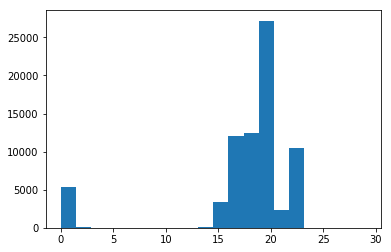

In [78]:
plt.hist([ed.eval(lines[len(lines)//2 + 1], x) for x in lines], bins = 20)

In [71]:
with open("../data/student_Dvyg/EC/gz/25_0_0_grep") as f:
    lines = [x[:-1] for x in f.readlines()]

In [83]:
lines[-2]

'CGCTGGCGCGGGGAACACACATGAATGTCGGTTCAGACCGTGTTTTTACCCGGTTTATCCCCGCTGGCGCGGGGAACACAGTGCTGGACCATTTCAAATTCACAATAGATTCGGTTTATCCCCGCTGGCGCGGGGAACACGGAAAGATCGG'

In [80]:
split_read(lines[0], lines[0], ecoli_r_1, e = 6)

([-1, -1], [-1, -1])

In [82]:
ecoli_r_1.rc

'GCCAAATAGGGGCGACCGCGCCCCTTGWG'

In [85]:
rc(ecoli_r_1.rc)[::-1]

'CWCAAGGGGCGCGGTCGCCCCTATTTGGC'

In [86]:
%load_ext autoreload
%autoreload 2

In [79]:
ecoli_r = Repeat("GWGTTCCCC(GCGCCAGCG)GGGATAAACCG", 
                   "GWGTTCCCCGCGCCAGCG",
                   "GCGCCAGCGGGGATAAACCG",
                   "GWGTTCCCCGCGCCAGCGGGGATAAACCG")

ecoli_r_1 = Repeat("GWGTTCCCC(GCGCCAGCG)GGGATAAACCG", 
                   "GCCAAATAGGGGCGACCGCG",
                   "GCGACCGCGCCCCTTGWG",
                   "GCCAAATAGGGGCGACCGCGCCCCTTGWG")


In [ ]:
v

In [97]:
[[len(x) for x in y] for y in answ]

[[32, 32, 32, 32, 31, 32, 32, 32],
 [32, 32, 32, 32, 31, 32, 32, 32, 32, 32, 32, 32, 32, 33, 34, 30],
 [29, 30, 31, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32],
 [32, 31, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32]]

In [106]:
(np.array([len(x) for y in res_20_1[0] for x in y]) == 28).sum()

44213

(array([1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00,
        0.0000e+00, 3.0000e+00, 2.3050e+03, 4.4213e+04, 1.9110e+03,
        7.0600e+02, 2.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([15.  , 16.55, 18.1 , 19.65, 21.2 , 22.75, 24.3 , 25.85, 27.4 ,
        28.95, 30.5 , 32.05, 33.6 , 35.15, 36.7 , 38.25, 39.8 , 41.35,
        42.9 , 44.45, 46.  ]),
 <a list of 20 Patch objects>)

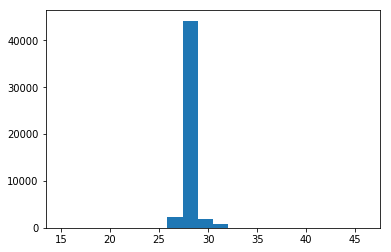

In [101]:
plt.hist([len(x) for y in res_20_1[0] for x in y], bins =20)

In [20]:
IUPAC_WILDCARDS

{'W': 'AT',
 'S': 'CG',
 'M': 'AC',
 'K': 'GT',
 'R': 'AG',
 'Y': 'CT',
 'B': 'CGT',
 'D': 'AGT',
 'H': 'ACT',
 'V': 'ACG',
 'N': 'ACGT'}

In [63]:
save_pairs("../data/clostr_Polina/pairs/", names[0], pairs)

In [ ]:
def save_pairs(path, name, pairs):
    name = name.split(".")[0]
    with open(path + name, 'w') as f:
        for p in pairs:
            f.write("\t".join(p))
            f.write("\n")
            

In [ ]:
[save_pairs(path, names[0]+'pairs', )]

In [18]:
reads, qualities = read_fastq(path)

In [20]:
pairs, pairs_q = [], []
for r,q in tqdm_notebook(zip(reads, qualities)):
    p, pq = split_read(r, q, repeat, repeat_s, repeat_e)
    pairs.append(p)
    pairs_q.append(pq)

In [22]:
pairs = np.array(pairs)
pairs_q = np.array(pairs_q)

In [25]:
mask = np.array(['-1' not in pair for pair in tqdm_notebook(pairs)])

print(mask.sum())

pairs = pairs[mask]
pairs_q = pairs_q[mask]

A Jupyter Widget


28815


In [53]:
min_pq = np.array([get_lowest_q(pq) for pq in pairs_q])

In [363]:
pairs = np.array(pairs)

In [375]:
mask = np.array(['-1' not in pair for pair in pairs])

In [379]:
pairs[mask]

array([['GAGGAGATTCAGACAGCGACTAAAAAGACTGATATA',
        'AACTTTATATCTCCANTTGCATATCCATCTGATGA'],
       ['GCGTACAAGGTTGAGAAGCTCCGCAATCTCAACGTC',
        'CAGCCAAAAACTTCGAATTTGAACTAAAATGCGT'],
       ['AGGAGATAACTTCTATTAAAGATAACTTTGATGTG',
        'GCGTACAAGGTTGAGAAGCTCCGCAATCTCAACGTC'],
       ...,
       ['AACTTTATATCTCCATTTGCATATCCATCTGATGA',
        'GCGTACAAGGTTGAGAAGCTCCGCAATCTCAACGTC'],
       ['AACTTTATATCTCCATTTGCATATCCATCTGATGC',
        'GCGTACAAGGTTGAGAAGCTCCGCAATCTCAACGTC'],
       ['GCTTACAAGGTTGAGAAGCTCCGCAATCTCAAAGTCGT',
        'ATTTGAAATGAATAAATTTTAAATGAATGAAAGTATAG']], dtype='<U105')

(array([     0.,      0.,      0.,      0.,      0., 128171.,      0.,
             0.,      0.,      0.]),
 array([150.5, 150.6, 150.7, 150.8, 150.9, 151. , 151.1, 151.2, 151.3,
        151.4, 151.5]),
 <a list of 10 Patch objects>)

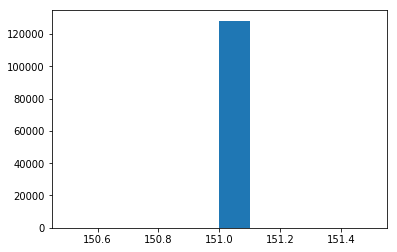

In [299]:
plt.hist([len(x) for x in reads])

In [312]:
len(quality_symbols)

95

In [313]:
quality_symbols[:15]

'!"#$%&\\\'()*+,-.'

In [316]:
qualities[100]

'AFFAFF=FFAFFFFFFFAFFFFFAFFFAFFFFFFFFFFFFFFFFFFFFFFFAFFFFFF/FFFFFFF6FAAFFFFFFFFF=FFFFFFFFFAFFFFFFFAFFF/FAFAF/FFFFF/FFF/FFFFFF=FFFFFFFFF/FFF/FFFFFFFFFFFF'

In [318]:
#  [sum([y in x for x in np.array(qualities)[mask]]) for y in quality_symbols]

In [232]:
p_str = repeat_to_re_pattern("(AAd)") 

In [233]:
p_str

'(AAd){e<=2}'

In [243]:
#p = re.compile("(AAAC){e<=2}")
p = re.compile(p_str)

In [244]:
[x.span() for x in re.finditer(p, "AAAA")]

[]

In [259]:
p_str = repeat_to_re_pattern(repeat,e=6)
p = re.compile(p_str)
print(p_str)

(GTTTTA[G|T]ATTAACTA[A|T][A|G]TGG[A|T]ATGTAAA[G|T]){e<=6}


In [260]:
[x.span() for x in re.finditer(p, reads[1])]

[(52, 84)]

In [261]:
reads[1][52:84]

'GGGTTTTAGATTAACTAAATGGAGATCGGAAG'

In [268]:
len(reads[1])

151

In [267]:
print_together(reads[1][54:84], repeat_clear)

G G
T T
T T
T T
T T
A A
G K
A A
T T
T T
A A
A A
C C
T T
A A
A W
A R
T T
G G
G G
A W
G A
A T
T G
C T
G A
G A
A A
A K


In [263]:
def print_together(s1, s2):
    for a,b in zip(s1, s2):
        print(a,b)

In [254]:
for  a,b in zip(reads[0], repeat[12:]):
    print(a, b)

A A
C C
T T
A A
T W
G R
T T
G G
G G
A )
A W
T A
G T
T G
A T
A A
A A
T A
G K


In [17]:
def repeat_matches(read, repeat, wildcards):
    pass

In [102]:
"|".join("ANB")

'A|N|B'

## import bio

In [154]:
from Bio.Seq import Seq
from Bio.Alphabet import generic_nucleotide
from Bio.Alphabet import IUPAC
nuc_seq = Seq("GATCGATGC", generic_nucleotide)
dna_seq = Seq("ACGTW", IUPAC.unambiguous_dna)

In [152]:
IUPAC.ambiguous_dna

'GATCRYWSMKHBVDN'

In [151]:
IUPAC_WILDCARDS

{'W': 'AT',
 'S': 'CG',
 'M': 'AC',
 'K': 'GT',
 'R': 'AG',
 'Y': 'CT',
 'B': 'CGT',
 'D': 'AGT',
 'H': 'ACT',
 'V': 'ACG',
 'N': 'ACGT'}

## RE

In [206]:
import regex as re

In [96]:
p = re.compile('a[d|b]c')

In [98]:
re.findall(p, 'aabddcx')

[]

## Mastering spades

In [55]:
import sys
sys.path.append("../spget/")

from importlib import reload

In [56]:
import spget as sp
sp = reload(sp)

In [92]:
# path = "../data/clostr_test/fastq/test_1.fastq"
# path = "../data/scripts/raw_data_clostr.fastq"
r_path = "../data/clostr_Polina/primers.txt"
rep = sp.load_repeats(r_path)













1	GTTTTAKATTA(ACTAWRTGG)WATGTAAAK	6



loading repeats from ../data/clostr_Polina/primers.txt


In [93]:
all_mm = {}
b = {}
sp.fill_parts(rep, all_mm, b )


using following repeats sequences:
seq: GTTTTAKATTAACTAWRTGGWATGTAAAK id: 0 types: 1(|1) mismatches: 6
seq: ACTAWRTGGWATGTAAAK id: 1 types: 1( mismatches: 6
seq: GTTTTAKATTAACTAWRTGG id: 2 types: 1) mismatches: 6


In [94]:
all_mm['GTTTTAKATTAACTAWRTGGWATGTAAAK']['RE_FUZZY']

regex.Regex('(?:GTTTTAKATTAACTAWRTGGWATGTAAAK){s<=6,i<=0,d<=0}', flags=regex.V0)

In [65]:
lines, q= read_fastq("../data/clostr_Polina/fastq/Polina-1_S11_L001_R1_001.fastq")

In [80]:
for pat in a:
    mm = all_mm[pat]["MM"]
    ins = all_mm[pat]["INS"]
    dl = all_mm[pat]["DEL"]
    pat_sys = all_mm[pat]["SYS"]
    pat_type = all_mm[pat]["TYPE"]
    pat_re_fuzzy = all_mm[pat]["RE_FUZZY"]
    pat_id = all_mm[pat]["ID"]
    found = sp.fuzzy_find_seq(lines[0], pat, mm, ins, dl, pat_re_fuzzy, pat_type, pat_id)

In [82]:
found

In [91]:
all_mm

{'GTTTTAKATTAACTAWRTGGWATGTAAAK': {'MM': 2,
  'INS': 0,
  'DEL': 0,
  'SYS': {'1'},
  'TYPE': {'1(', '1)'},
  'ID': '0',
  'DA_SET': set(),
  'RE_FUZZY': regex.Regex('(?:GTTTTAKATTAACTAWRTGGWATGTAAAK){s<=2,i<=0,d<=0}', flags=regex.V0)},
 'ACTAWRTGGWATGTAAAK': {'MM': 2,
  'INS': 0,
  'DEL': 0,
  'SYS': {'1'},
  'TYPE': {'1('},
  'ID': '1',
  'DA_SET': set(),
  'RE_FUZZY': regex.Regex('(?:ACTAWRTGGWATGTAAAK){s<=2,i<=0,d<=0}', flags=regex.V0)},
 'GTTTTAKATTAACTAWRTGG': {'MM': 2,
  'INS': 0,
  'DEL': 0,
  'SYS': {'1'},
  'TYPE': {'1)'},
  'ID': '2',
  'DA_SET': set(),
  'RE_FUZZY': regex.Regex('(?:GTTTTAKATTAACTAWRTGG){s<=2,i<=0,d<=0}', flags=regex.V0)}}

In [105]:
coords = sp.get_system_coords(lines[1], all_mm)

In [108]:
split_read(lines[0], q[1], redundant.rc, redundant.rs, redundant.re, v =1)

[(54, 85), (120, 151)]
[(0, 18)]
[(35, 57)]


(['GAGGAGATTCAGACAGCGACTAAAAAGACTGATATA',
  'AACTTTATATCTCCANTTGCATATCCATCTGATGA'],
 ['FFFFFFFFFFFFFFFF/FFAFFFFFFFFFFFFFFFF',
  'FFFFFFFFFFFFFFFFFFFFFFFFFFFFF=F/=//'])

In [72]:
a['GTTTTAKATTAACTAWRTGGWATGTAAAK']

{'MM': 2,
 'INS': 0,
 'DEL': 0,
 'SYS': {'1'},
 'TYPE': {'1(', '1)'},
 'ID': '0',
 'DA_SET': set(),
 'RE_FUZZY': regex.Regex('(?:GTTTTAKATTAACTAWRTGGWATGTAAAK){s<=2,i<=0,d<=0}', flags=regex.V0)}

In [ ]:
sp.fuzzy_find_seq()

In [45]:
sp.rc(raw)

'ATTTACATTCCATATAGTTAATCTAAAACGTTCATCAGATGGATATGCAANTGGAGATATAAAGTTATTTACATTCCATATAGTTAATCTAAAACTTTATATCAGTCTTTTTAGTCGCTGTCTGAATCTCCTCATTTACATTCCACATAGT'

In [53]:
for r in raw:
    print(sp.get_system_coords(sp.rc(r), a))

{}
{}
{}
{}
{}
{}
{}
{}


In [54]:
for r in raw:
    print(sp.get_system_coords(r, a))

{}
{}
{}
{}
{}
{}
{}
{}


In [56]:
from spget import * 

In [58]:
path = "../data/clostr_test/fastq/test_1.fastq"
path = "../data/scripts/raw_data_clostr.fastq"
r_path = "../data/scripts/primers.txt"
#rep = sp.load_repeats(r_path)

In [ ]:
repeats = load_repeats(r_path)
if not repeats:
    warn("no repeats loaded, exiting")
    exit(1)

all_mm = {}
id2primers = {}
fill_parts(repeats, all_mm, id2primers)


warn("\ntrimming...")

In [66]:
start_time = time.time()
for cnt, line in enumerate(lines, start = 1):
#     if cnt % time_each == 0 or cnt == args.time_first:
#         warn("\nprocessed " + str(cnt) + " reads in " + str_time(start_time) + " ...")
#     if of_parts and cnt % of_parts != part:
#         continue

    print(line)
    rec = list(map(lambda x: x.strip(), line.strip().split("\t")))
    rec += [""]
    print(rec)
    place, read_id, seq, qual = rec[0:4]

    rc_seq = rc(seq)
    rc_qual = qual[::-1]

    res = get_system_coords(seq, all_mm)
    res_rc = get_system_coords(rc_seq, all_mm)

#     both_dirs = res and res_rc
#     dump_read(place, read_id, res, seq, id2primers, both_dirs, "+", qual, args.dump_linked_ids)
#     dump_read(place, read_id, res_rc, rc_seq, id2primers, both_dirs, "-", qual, args.dump_linked_ids)

# warn("\nprocessed " + str(cnt) + " reads in " + str_time(start_time) + " ...")
# warn("\ndone...")

home	@MN00409:27:000H2KHTM:1:11102:17147:1044 1:N:0:11	ACTATGTGGAATGTAAATGAGGAGATTCAGACAGCGACTAAAAAGACTGATATAAAGTTTTAGATTAACTATATGGAATGTAAATAACTTTATATCTCCANTTGCATATCCATCTGATGAACGTTTTAGATTAACTATATGGAATGTAAAT	AFFAFFFFFF/FAFFFFFF6FFFFFFFFFFAFFFFFFFFFFFFFFFFF/FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF/FFFFFFFFFFFFF/FFF#FFFFFFFFFFFFFFFFFFFFF6FFFFFAFFFFFF//FAAAFA//FFAFFF

['home', '@MN00409:27:000H2KHTM:1:11102:17147:1044 1:N:0:11', 'ACTATGTGGAATGTAAATGAGGAGATTCAGACAGCGACTAAAAAGACTGATATAAAGTTTTAGATTAACTATATGGAATGTAAATAACTTTATATCTCCANTTGCATATCCATCTGATGAACGTTTTAGATTAACTATATGGAATGTAAAT', 'AFFAFFFFFF/FAFFFFFF6FFFFFFFFFFAFFFFFFFFFFFFFFFFF/FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF/FFFFFFFFFFFFF/FFF#FFFFFFFFFFFFFFFFFFFFF6FFFFFAFFFFFF//FAAAFA//FFAFFF', '']
home	@MN00409:27:000H2KHTM:1:11102:23264:1052 1:N:0:11	ACTATGTGGAATGTAAATCAGCCAAAAACTTCGAATTTGAACTAAAATGCGTGGGTTTTAGATTAACTAAATGGAGATCGGAAGAGCACACGTCTGAACTCCAGTCACCCAGTATCATCTCGTATGCCGTCTTCGGCTTGAAAAAAATAAG	AAAFFFFFFF/FFFFFFFFFFFFFFFFFFFFFFF/FFAFFFFFFFFFFFFFFFFFFF

In [74]:
def get_system_coords(seq, all_mm):
    out = defaultdict(list)
    for pat in all_mm:
        mm = all_mm[pat]["MM"]
        ins = all_mm[pat]["INS"]
        dl = all_mm[pat]["DEL"]
        pat_sys = all_mm[pat]["SYS"]
        pat_type = all_mm[pat]["TYPE"]
        pat_re_fuzzy = all_mm[pat]["RE_FUZZY"]
        pat_id = all_mm[pat]["ID"]
        found = fuzzy_find_seq(seq, pat, mm, ins, dl, pat_re_fuzzy, pat_type, pat_id)
        print(found)
        if found:
            for sys in pat_sys:
                out[sys] += found
    res = {}
    for sys in out:
        pruned = prune_matches(out[sys], sys)
        if pruned:
            res[sys] = pruned
    return res


In [83]:
def fuzzy_find_seq(where, what, mm, ins, dl, what_re_fuzzy, pat_type = None, pat_id = None):
    '''returns [(mm, from, to, substr)]'''
    if mm < 0:
        mm = 0
        
        
    print(what_re_fuzzy)
        
    print(where, "\n", what)
    out = []
    
    print(what_re_fuzzy.find(where, overlapped=True))
    positions = [(i.span()[0], i.span()[1], i[0], i.fuzzy_counts[0], i.fuzzy_counts[1], i.fuzzy_counts[2]) for i in what_re_fuzzy.finditer(where, overlapped=True)]

    positions = filter(lambda x: x[3] <= mm and x[4] <= ins and x[5] <= dl, positions)
    
    for frm, to, match, dist_mm, dist_ins, dist_del in positions:
        out.append((dist_mm + dist_ins + dist_del, frm, to, match, pat_type, pat_id))
    if not out:
        return None
    return out

In [89]:
re = all_mm['GTTTTAKATTAACTAWRTGGWATGTAAAK']['RE_FUZZY']

In [91]:
re

regex.Regex('(?:GTTTTAKATTAACTAWRTGGWATGTAAAK){s<=2,i<=0,d<=0}', flags=regex.V0)

In [90]:
re.findall(raw[0])

[]

In [84]:
get_system_coords(raw[0], all_mm)

regex.Regex('(?:GTTTTAKATTAACTAWRTGGWATGTAAAK){s<=2,i<=0,d<=0}', flags=regex.V0)
ACTATGTGGAATGTAAATGAGGAGATTCAGACAGCGACTAAAAAGACTGATATAAAGTTTTAGATTAACTATATGGAATGTAAATAACTTTATATCTCCANTTGCATATCCATCTGATGAACGTTTTAGATTAACTATATGGAATGTAAAT 
 GTTTTAKATTAACTAWRTGGWATGTAAAK
None
regex.Regex('(?:ACTAWRTGGWATGTAAAK){s<=2,i<=0,d<=0}', flags=regex.V0)
ACTATGTGGAATGTAAATGAGGAGATTCAGACAGCGACTAAAAAGACTGATATAAAGTTTTAGATTAACTATATGGAATGTAAATAACTTTATATCTCCANTTGCATATCCATCTGATGAACGTTTTAGATTAACTATATGGAATGTAAAT 
 ACTAWRTGGWATGTAAAK
None
regex.Regex('(?:GTTTTAKATTAACTAWRTGG){s<=2,i<=0,d<=0}', flags=regex.V0)
ACTATGTGGAATGTAAATGAGGAGATTCAGACAGCGACTAAAAAGACTGATATAAAGTTTTAGATTAACTATATGGAATGTAAATAACTTTATATCTCCANTTGCATATCCATCTGATGAACGTTTTAGATTAACTATATGGAATGTAAAT 
 GTTTTAKATTAACTAWRTGG
None


{}

In [ ]:
fuzzy_find_seq(raw[0], )

In [2]:
False and 'T' or 'F'

'F'